# Taxi Fare Price Prediction
**The project is about on world's largest taxi company In this project, we're looking to predict the fare for their future transactional cases. The company delivers service to lakhs of customers daily. Now it becomes really important to manage their data properly to come up with new business ideas to get best results. Eventually, it becomes really important to estimate the fare prices accurately.
The dataset contains the following fields:**
- key - a unique identifier for each trip
- fare_amount - the cost of each trip in usd
- pickup_datetime - date and time when the meter was engaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
import tensorflow as tf

2023-04-25 08:42:02.276962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('Data2_reg.csv')

# **Data Cleaning and Preprocessing**
### 

In [3]:
#Checking the shape of dataset
print(df.shape)

(120000, 9)


In [4]:
#Checking for null values
df.isnull().sum()

Unnamed: 0           0
key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

In [5]:
#Removing the unnecessary columns
df.drop(['Unnamed: 0','key'],axis = 1, inplace = True)

In [6]:
#removing the null values
df.dropna(inplace = True)

In [7]:
#Checking for duplicates
print(df.duplicated().sum())

0


In [8]:
#dropping records where the fare_amount is negative as it makes no sense
df = df[df['fare_amount'] >= 0]

In [9]:
df.shape

(119987, 7)

## **Feature Engineering**

In [10]:
def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
    
    
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)


def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    
    return df


def add_coordinate_features(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)

    return df


def add_distances_features(df):
    # Add distances from airpot and downtown
    
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    
    
    return df

In [11]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [12]:
df_added = add_time_features(df)

add_coordinate_features(df_added)

df_added = add_distances_features(df_added)

In [13]:
df_added.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan
0,-73.984187,40.743131,-73.959209,40.760516,1,11.5,2014,1,27,9,0,0,0,-0.017385,-0.024978,0.030433,0.042363
1,-73.994060,40.751118,-73.954027,40.771995,1,12.1,2010,7,25,18,6,0,0,-0.020877,-0.040033,0.045150,0.060910
2,-73.986884,40.756002,-73.962700,40.758064,1,7.7,2009,10,18,22,6,0,1,-0.002062,-0.024184,0.024272,0.026246
3,-73.969094,40.757042,-73.980620,40.784699,1,11.3,2010,8,26,22,3,0,1,-0.027657,0.011526,0.029963,0.039183
4,-73.978110,40.775018,-73.976168,40.750907,1,12.1,2011,7,27,18,2,1,0,0.024111,-0.001942,0.024189,0.026053


## Exploratory Data Analysis

In [14]:
df_added.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119987 entries, 0 to 119999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_longitude   119987 non-null  float64
 1   pickup_latitude    119987 non-null  float64
 2   dropoff_longitude  119987 non-null  float64
 3   dropoff_latitude   119987 non-null  float64
 4   passenger_count    119987 non-null  int64  
 5   fare_amount        119987 non-null  float64
 6   year               119987 non-null  int64  
 7   month              119987 non-null  int64  
 8   day                119987 non-null  int64  
 9   hour               119987 non-null  int64  
 10  weekday            119987 non-null  int64  
 11  night              119987 non-null  int64  
 12  late_night         119987 non-null  int64  
 13  latdiff            119987 non-null  float64
 14  londiff            119987 non-null  float64
 15  euclidean          119987 non-null  float64
 16  ma

In [15]:
df_added.corr()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan
pickup_longitude,1.000000,-0.917919,0.885420,-0.868517,0.001210,0.009365,0.007663,-0.004083,0.005334,0.002972,0.000779,0.000520,0.001795,-0.110632,0.312776,-0.074312,-0.034014
pickup_latitude,-0.917919,1.000000,-0.906263,0.921389,-0.003624,-0.009861,-0.009252,0.004229,-0.009172,-0.004306,-0.003638,0.000570,-0.001562,0.183233,-0.095992,-0.063002,-0.083597
dropoff_longitude,0.885420,-0.906263,1.000000,-0.941309,0.002406,0.010920,0.007378,-0.001282,0.004353,0.003973,0.000249,0.000183,0.002855,0.102800,-0.164534,0.032174,0.053873
dropoff_latitude,-0.868517,0.921389,-0.941309,1.000000,-0.003460,-0.010753,-0.009577,0.001709,-0.007419,-0.004569,-0.001957,-0.000029,-0.003081,-0.213232,0.080468,-0.032375,-0.052272
passenger_count,0.001210,-0.003624,0.002406,-0.003460,1.000000,0.005311,0.001296,0.012803,0.005785,0.012884,0.029728,-0.003572,0.018365,-0.000358,-0.002349,0.002631,0.001902
fare_amount,0.009365,-0.009861,0.010920,-0.010753,0.005311,1.000000,0.115683,0.023352,0.002335,-0.020806,0.007749,-0.018168,0.010427,0.002410,-0.002441,0.020278,0.022929
year,0.007663,-0.009252,0.007378,-0.009577,0.001296,0.115683,1.000000,-0.115654,-0.008986,0.003028,0.005983,-0.010489,0.005308,0.000966,0.001186,0.016009,0.019157
month,-0.004083,0.004229,-0.001282,0.001709,0.012803,0.023352,-0.115654,1.000000,-0.016924,-0.008818,-0.006985,-0.006046,0.007439,0.006307,-0.006046,0.000818,0.000750
day,0.005334,-0.009172,0.004353,-0.007419,0.005785,0.002335,-0.008986,-0.016924,1.000000,0.004343,0.006034,-0.001714,0.001715,-0.004290,0.002423,-0.000057,-0.000418
hour,0.002972,-0.004306,0.003973,-0.004569,0.012884,-0.020806,0.003028,-0.008818,0.004343,1.000000,-0.089122,0.362270,0.023771,0.000731,-0.001811,-0.001155,-0.001313


In [16]:
features = []

In [17]:
data = df_added[:][:500]

In [18]:
data

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan
0,-73.984187,40.743131,-73.959209,40.760516,1,11.5,2014,1,27,9,0,0,0,-0.017385,-0.024978,0.030433,0.042363
1,-73.994060,40.751118,-73.954027,40.771995,1,12.1,2010,7,25,18,6,0,0,-0.020877,-0.040033,0.045150,0.060910
2,-73.986884,40.756002,-73.962700,40.758064,1,7.7,2009,10,18,22,6,0,1,-0.002062,-0.024184,0.024272,0.026246
3,-73.969094,40.757042,-73.980620,40.784699,1,11.3,2010,8,26,22,3,0,1,-0.027657,0.011526,0.029963,0.039183
4,-73.978110,40.775018,-73.976168,40.750907,1,12.1,2011,7,27,18,2,1,0,0.024111,-0.001942,0.024189,0.026053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-73.989613,40.757977,-73.983190,40.777667,6,10.0,2014,5,6,20,1,1,1,-0.019690,-0.006423,0.020711,0.026113
496,-74.005320,40.736120,-73.990374,40.666131,1,20.5,2010,2,14,16,6,0,0,0.069989,-0.014946,0.071567,0.084935
497,-73.948845,40.828918,-73.953085,40.817728,1,4.9,2009,7,5,0,6,0,1,0.011190,0.004240,0.011966,0.015430
498,-73.956963,40.783310,-73.965523,40.766785,5,6.5,2010,2,16,12,1,0,0,0.016525,0.008560,0.018610,0.025085


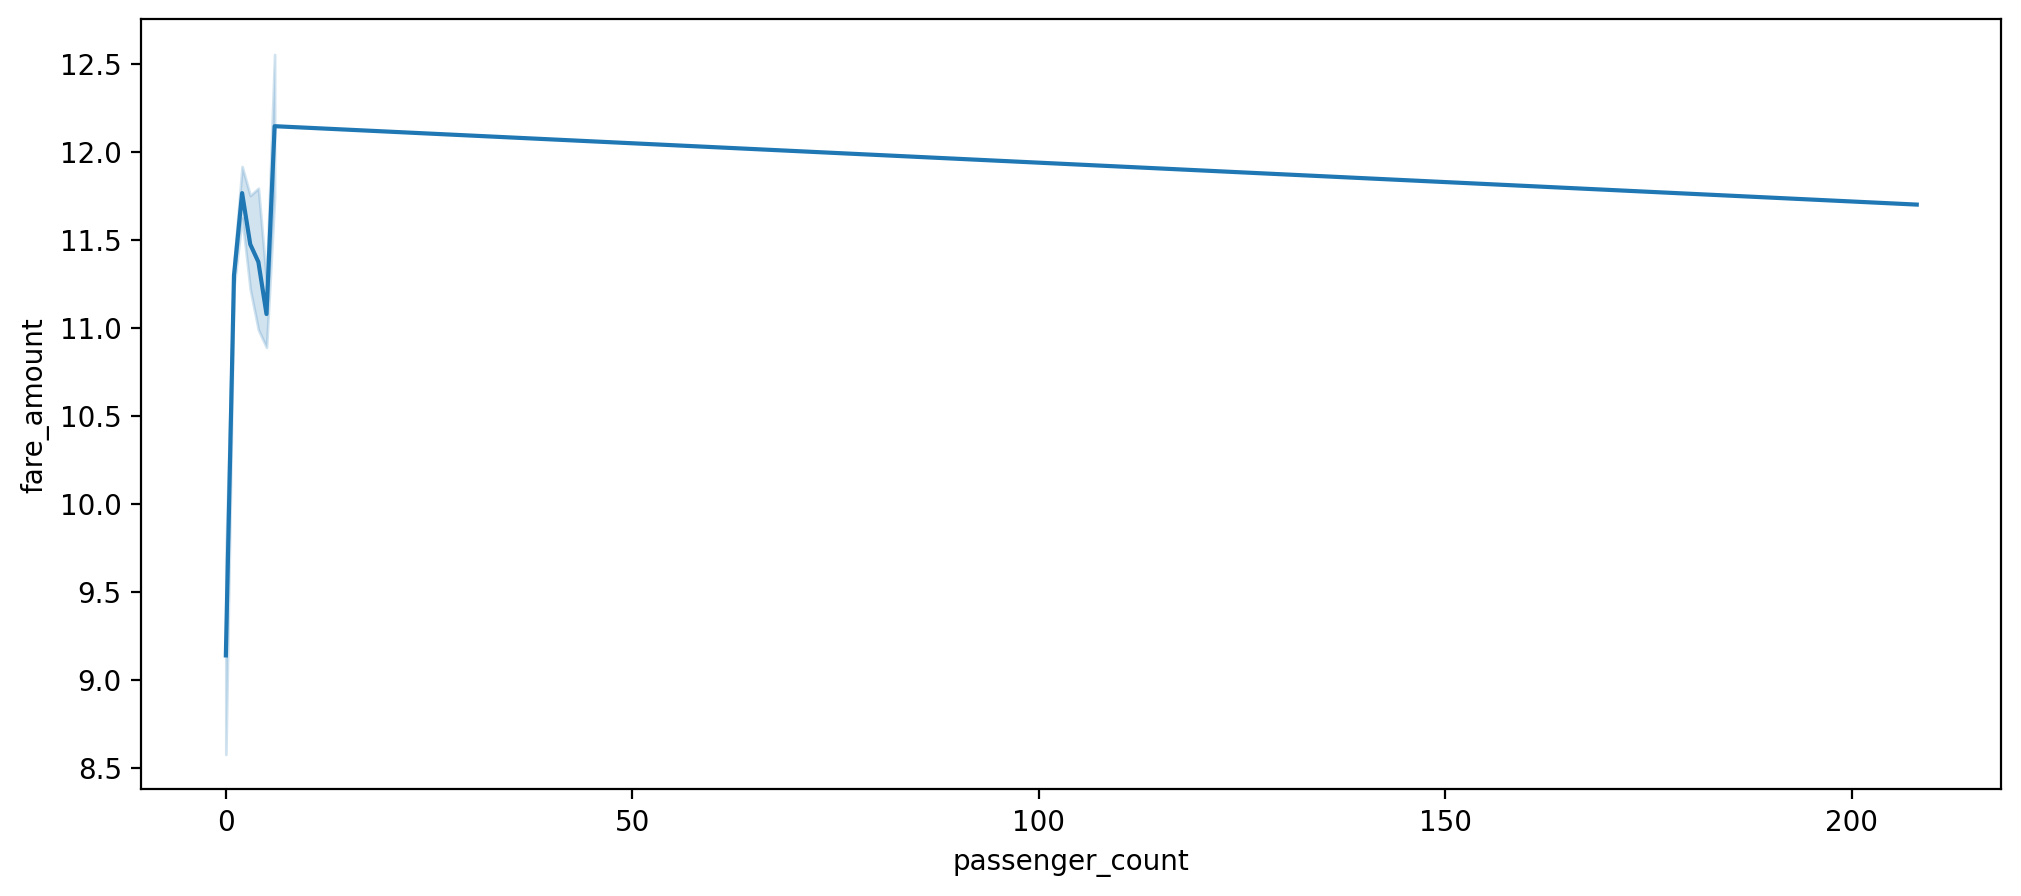

Addy


In [25]:
import seaborn as sns
feature = 'passenger_count'
plt.figure(figsize = (12,5), dpi = 200 )
sns.lineplot(x=feature, y='fare_amount', data = df_added)
plt.show()
c = input('Add')
if c == 'y':
    features.append(feature)

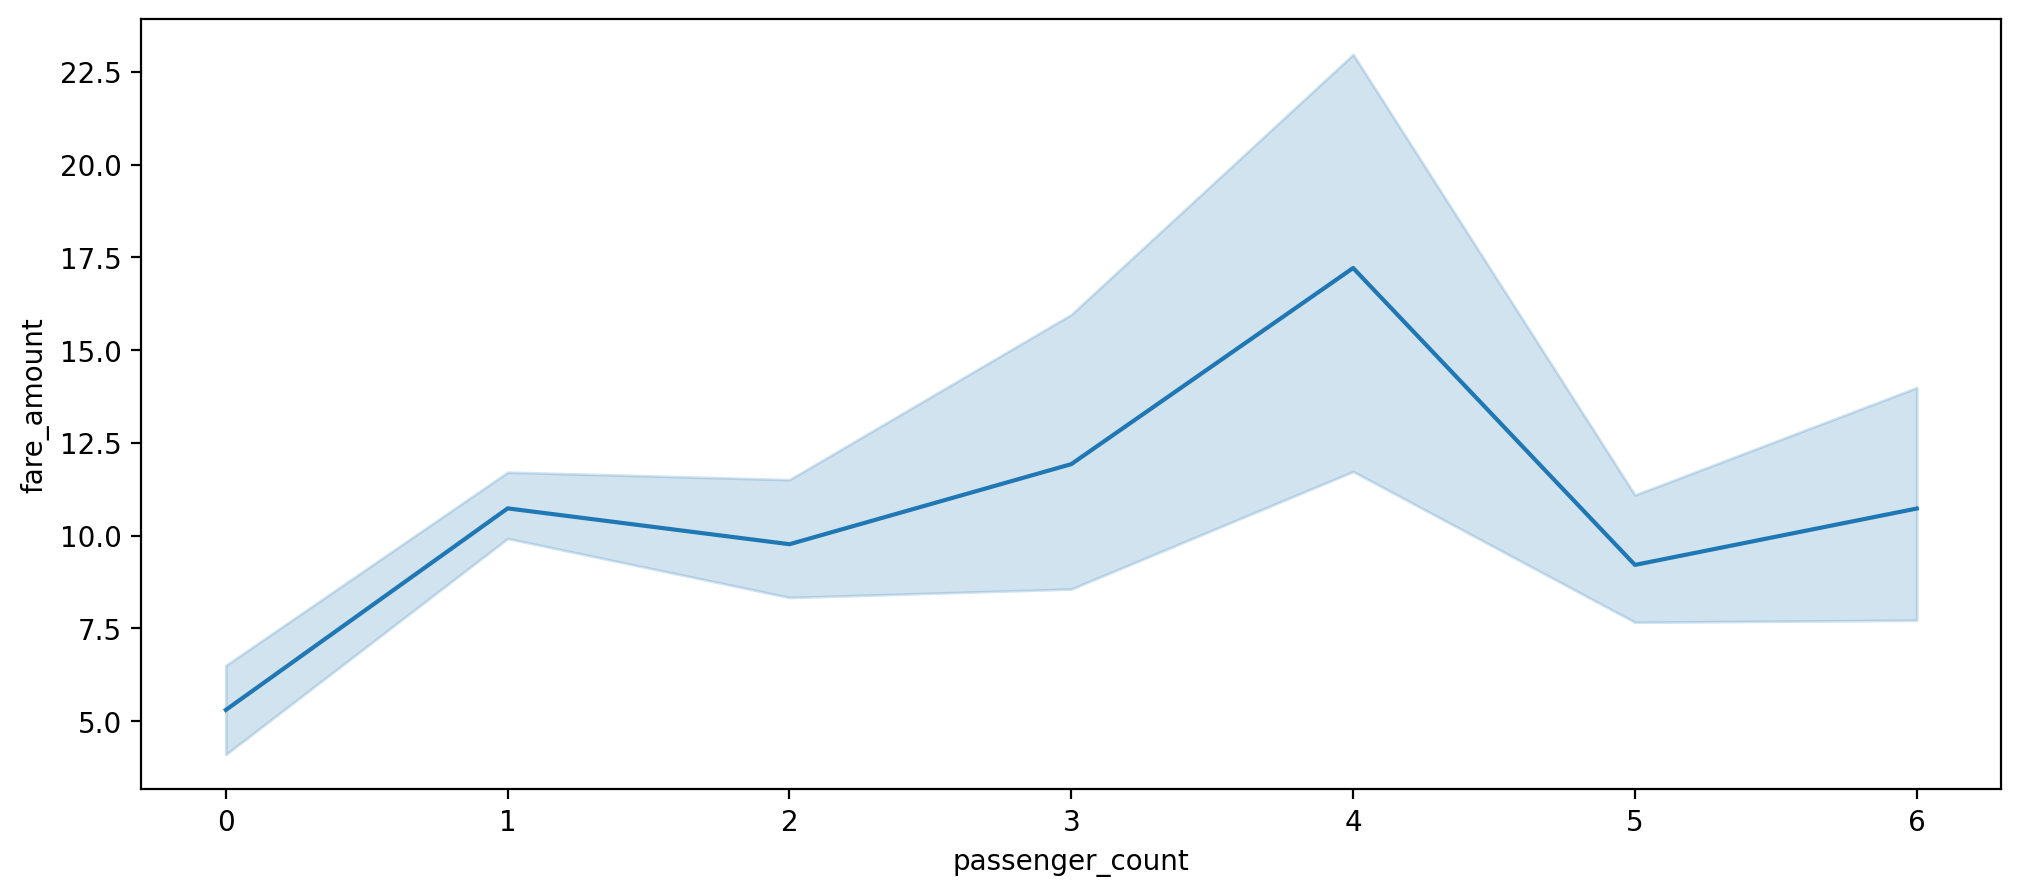

In [26]:
feature = 'passenger_count'
plt.figure(figsize = (12,5), dpi = 200 )
sns.lineplot(x=feature, y='fare_amount', data = data)
plt.show()

In [27]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df_added['pickup_longitude'], df_added['pickup_latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

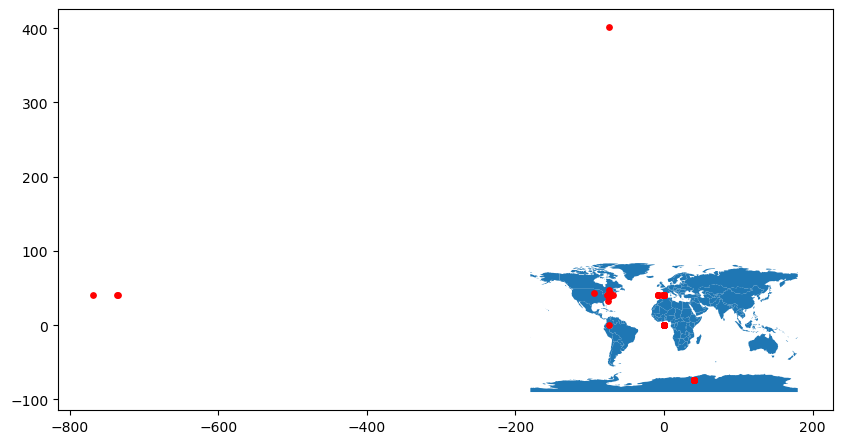

In [28]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [29]:
df_added = df_added[(df_added.pickup_latitude<90) & (df_added.dropoff_latitude<90) &
        (df_added.pickup_latitude>-90) & (df_added.dropoff_latitude>-90) &
        (df_added.pickup_longitude<180) & (df_added.dropoff_longitude<180) &
        (df_added.pickup_longitude>-180) & (df_added.dropoff_longitude>-180)]
len(df_added)

119981

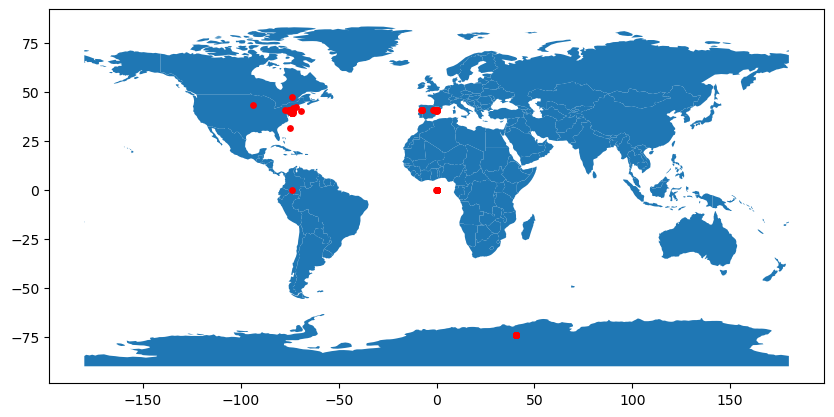

In [30]:
geometry = [Point(xy) for xy in zip(df_added['pickup_longitude'], df_added['pickup_latitude'])]
gdf = GeoDataFrame(df_added, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [31]:
df_added.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'fare_amount', 'year', 'month',
       'day', 'hour', 'weekday', 'night', 'late_night', 'latdiff', 'londiff',
       'euclidean', 'manhattan', 'geometry'],
      dtype='object')

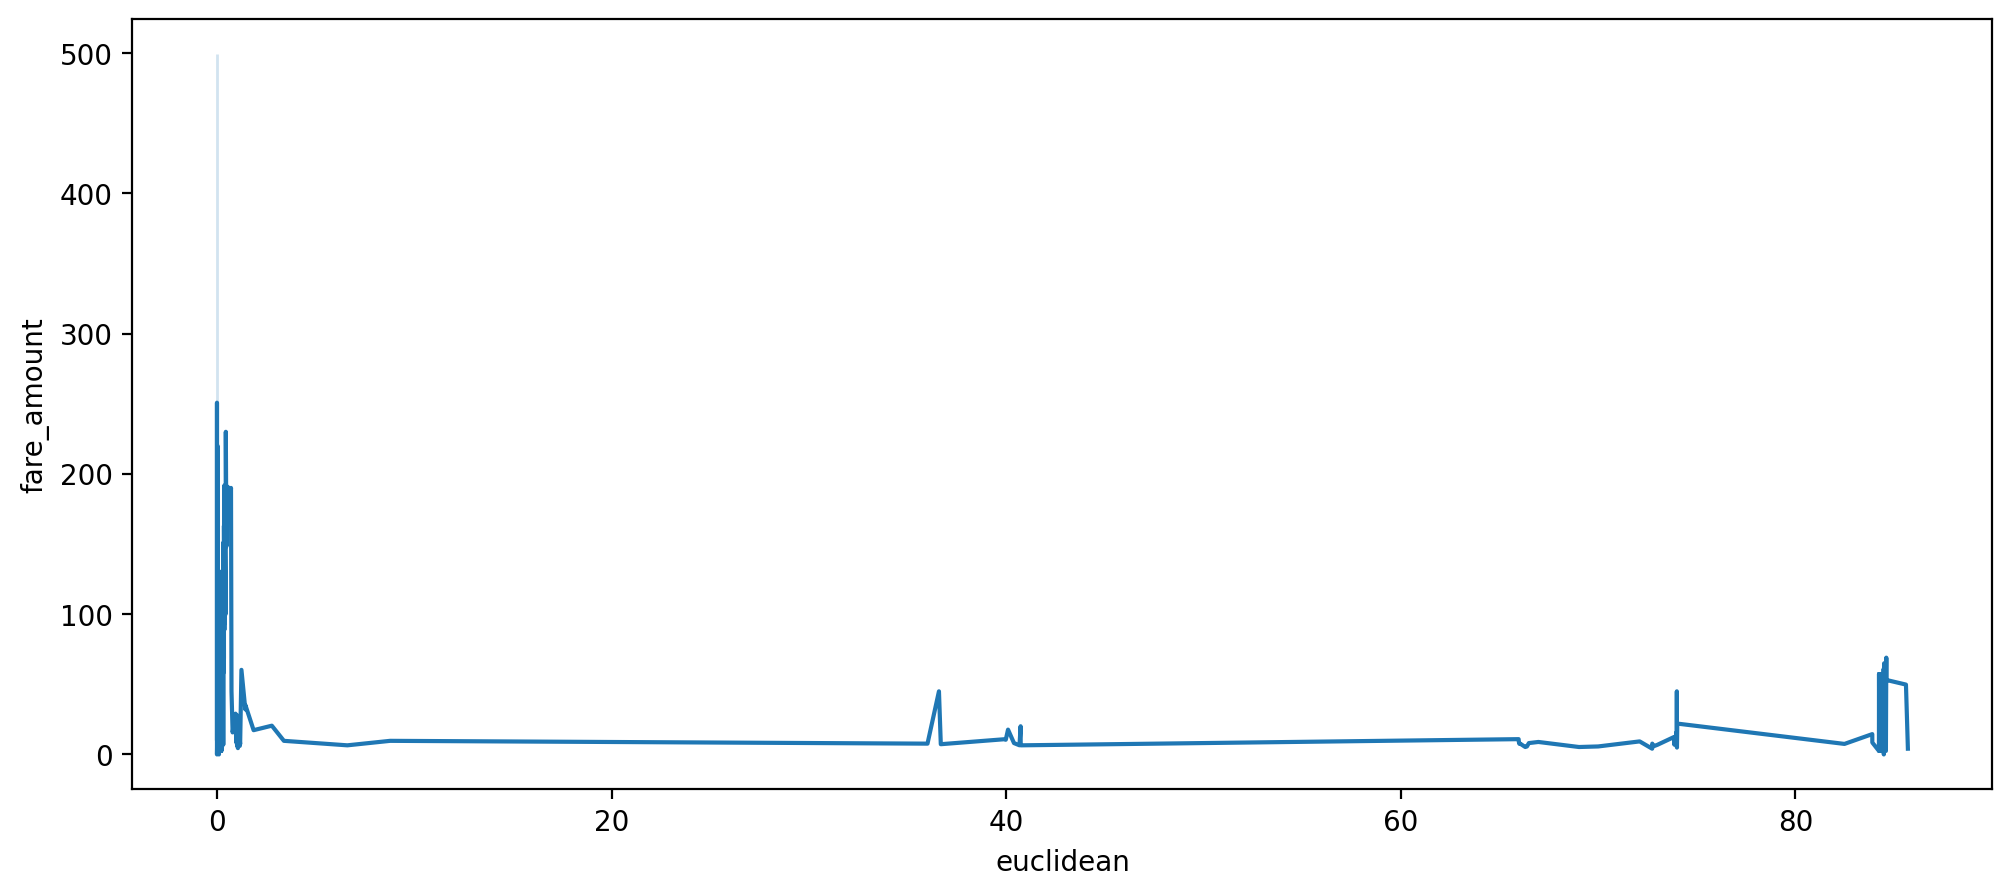

Addy


In [34]:
feature = 'euclidean'
plt.figure(figsize = (12,5), dpi = 200 )
sns.lineplot(x=feature, y='fare_amount', data = df_added)
plt.show()
c = input('Add')
if c == 'y':
    features.append(feature)

In [35]:
df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,weekday,night,late_night
count,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000,119987.000000
mean,-72.540181,39.934938,-72.541239,39.939861,1.684624,11.370551,2011.744497,6.279672,15.694284,13.477160,3.050522,0.199288,0.368807
std,10.906085,6.161273,10.502023,6.199539,1.435327,9.920119,1.856705,3.438810,8.689128,6.513633,1.949870,0.399467,0.482483
min,-768.550000,-74.015515,-737.916665,-74.015750,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-73.992057,40.734665,-73.991444,40.733903,1.000000,6.000000,2010.000000,3.000000,8.000000,9.000000,1.000000,0.000000,0.000000
50%,-73.981818,40.752507,-73.980113,40.752942,1.000000,8.500000,2012.000000,6.000000,16.000000,14.000000,3.000000,0.000000,0.000000
75%,-73.967137,40.767147,-73.963662,40.767977,2.000000,12.500000,2013.000000,9.000000,23.000000,19.000000,5.000000,0.000000,1.000000
max,40.808425,401.066667,40.831932,493.533332,208.000000,499.000000,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000


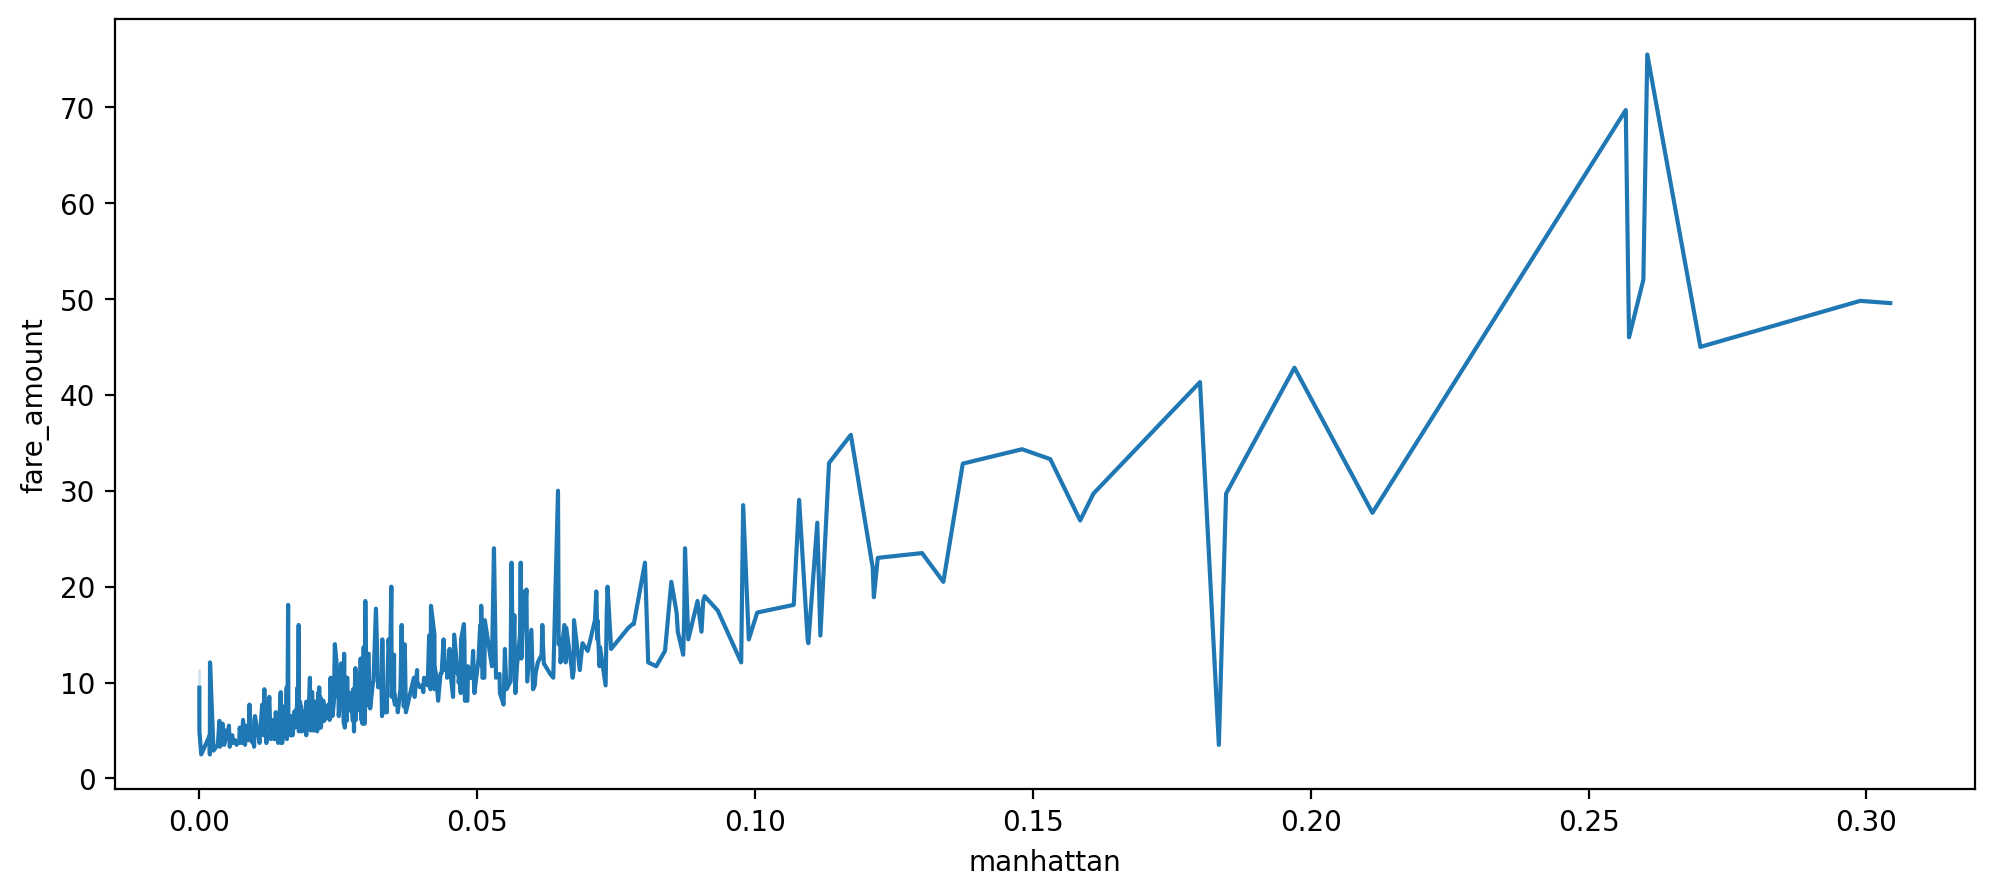

Addy


In [36]:
feature = 'manhattan'
plt.figure(figsize = (12,5), dpi = 200 )
sns.lineplot(x=feature, y='fare_amount', data = data)
plt.show()
c = input('Add')
if c == 'y':
    features.append(feature)

In [37]:
df_added.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'fare_amount', 'year', 'month',
       'day', 'hour', 'weekday', 'night', 'late_night', 'latdiff', 'londiff',
       'euclidean', 'manhattan', 'geometry'],
      dtype='object')

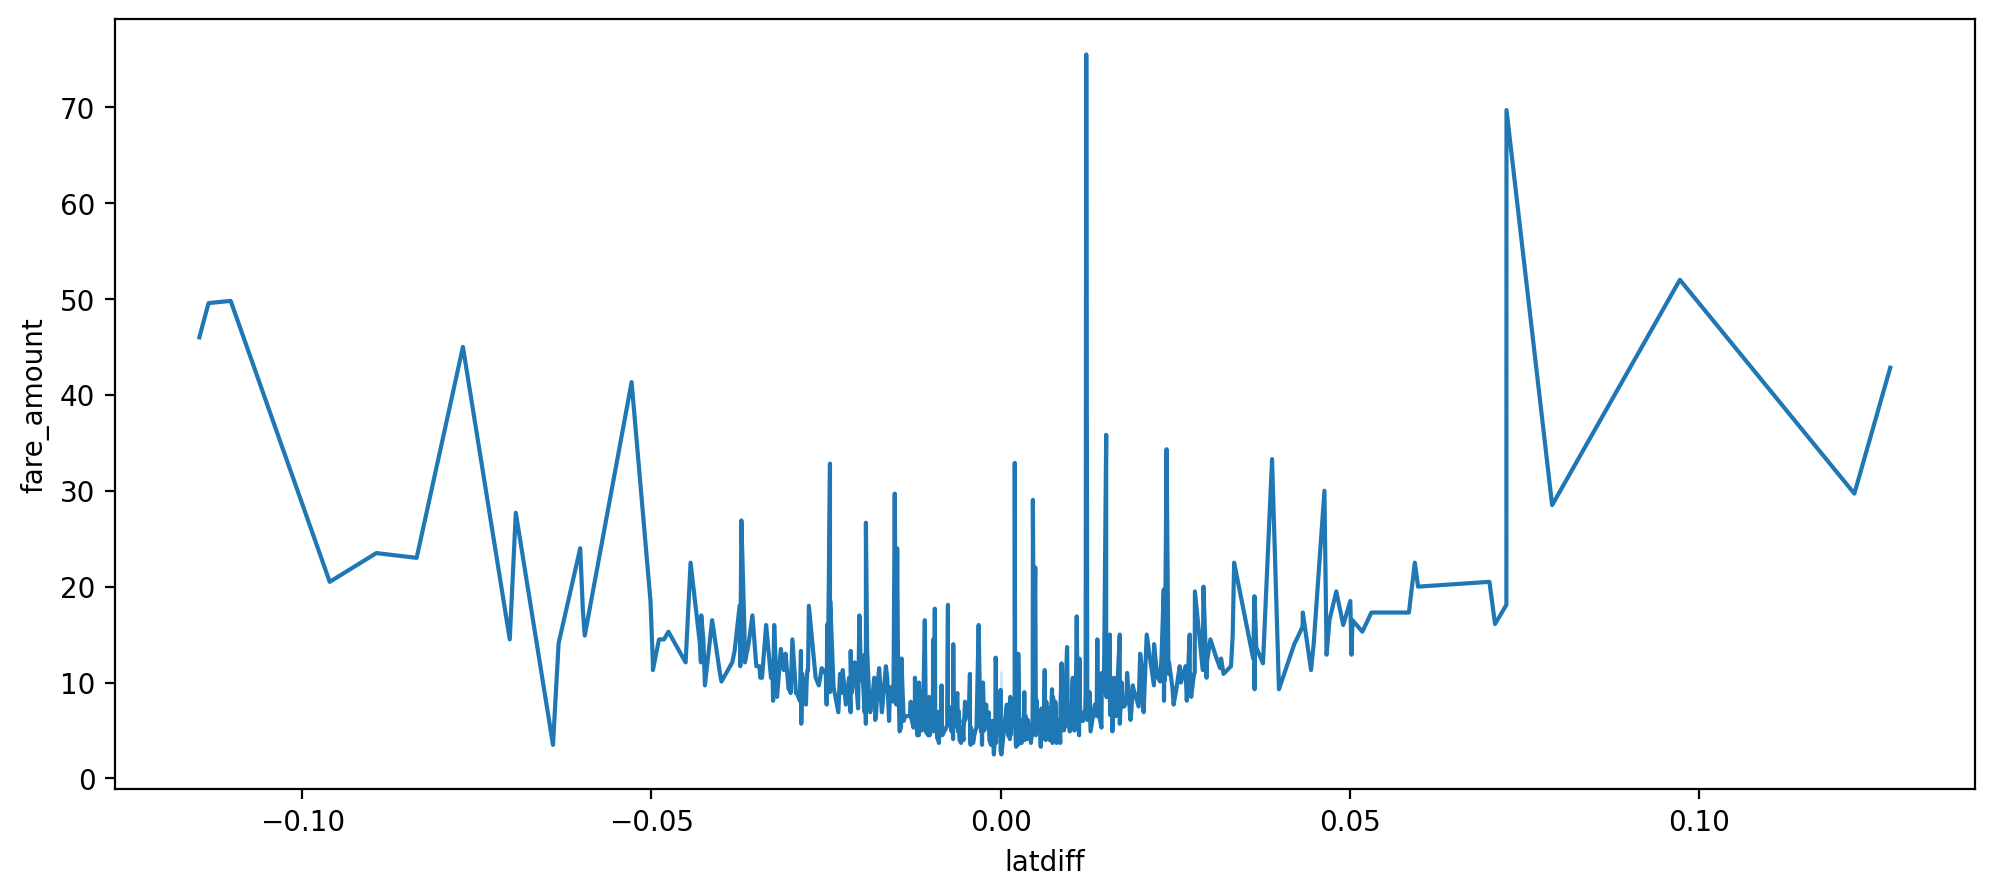

Addy


In [38]:
feature = 'latdiff'
plt.figure(figsize = (12,5), dpi = 200 )
sns.lineplot(x=feature, y='fare_amount', data = data)
plt.show()
c = input('Add')
if c == 'y':
    features.append(feature)

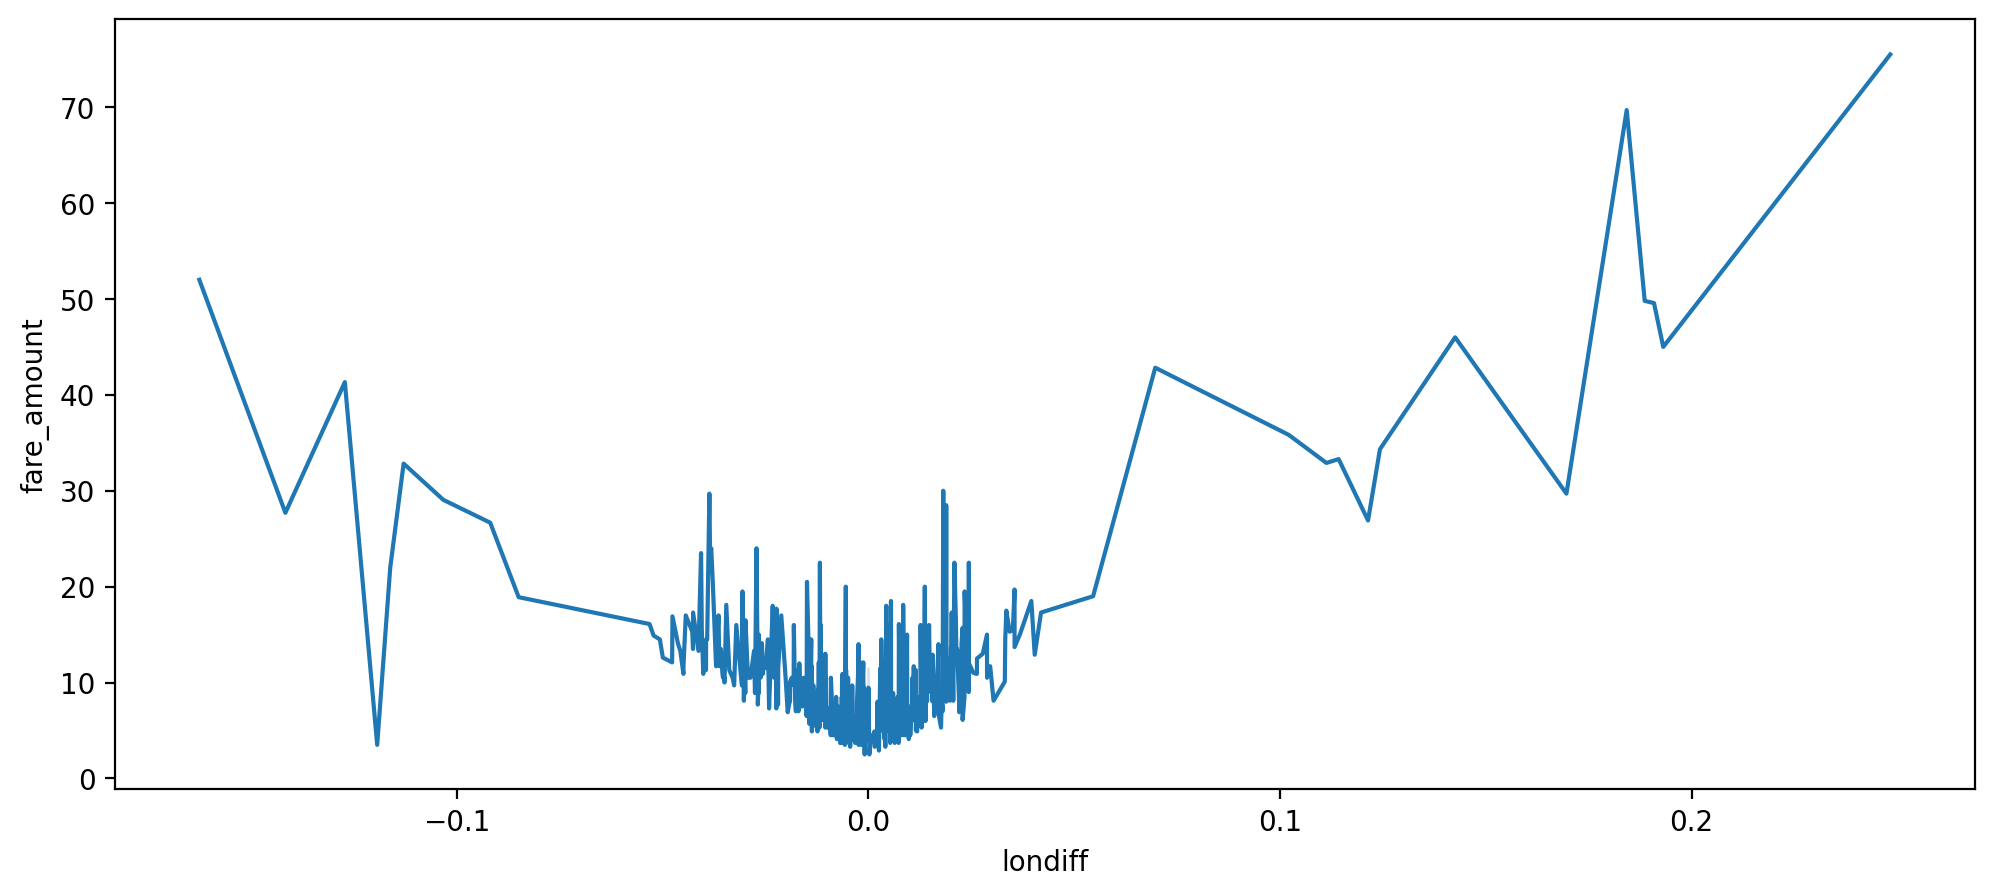

Addy


In [39]:
feature = 'londiff'
plt.figure(figsize = (12,5), dpi = 200 )
sns.lineplot(x=feature, y='fare_amount', data = data)
plt.show()
c = input('Add')
if c == 'y':
    features.append(feature)

In [40]:
features

['passenger_count',
 'passenger_count',
 'passenger_count',
 'euclidean',
 'euclidean',
 'manhattan',
 'latdiff',
 'londiff']

*Checking for categorical values*

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119987 entries, 0 to 119999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   pickup_datetime    119987 non-null  object  
 1   pickup_longitude   119987 non-null  float64 
 2   pickup_latitude    119987 non-null  float64 
 3   dropoff_longitude  119987 non-null  float64 
 4   dropoff_latitude   119987 non-null  float64 
 5   passenger_count    119987 non-null  int64   
 6   fare_amount        119987 non-null  float64 
 7   year               119987 non-null  int64   
 8   month              119987 non-null  int64   
 9   day                119987 non-null  int64   
 10  hour               119987 non-null  int64   
 11  weekday            119987 non-null  int64   
 12  night              119987 non-null  int64   
 13  late_night         119987 non-null  int64   
 14  geometry           119987 non-null  geometry
dtypes: float64(5), geometry(1), int64(

<Axes: >

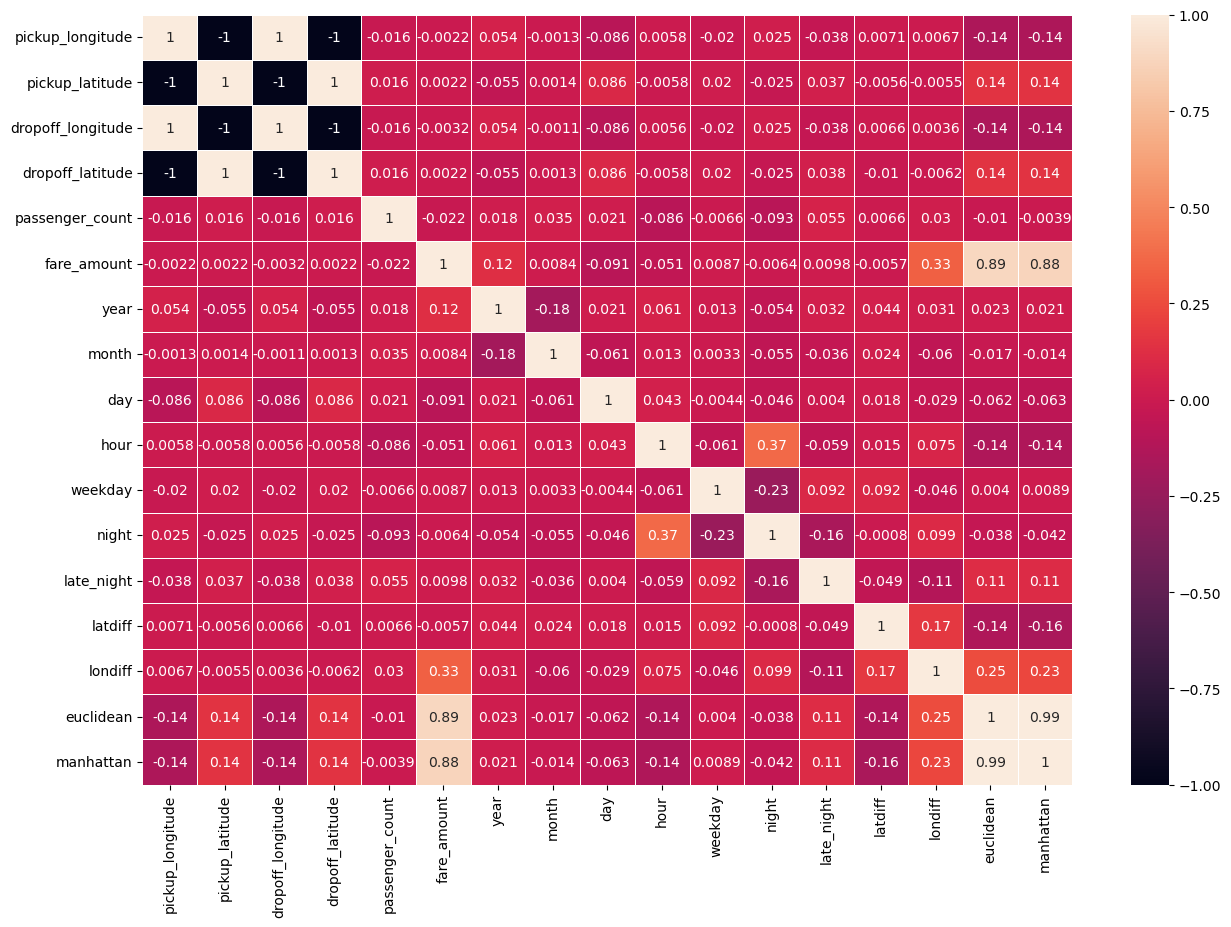

In [42]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, vmin = -1, vmax = 1, fmt = '.2g')

In [43]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


X = df_added[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'fare_amount']]

# Define the number of clusters
n_clusters = 3

# Initialize KMeans algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit KMeans to the data
kmeans.fit(X)

labels = kmeans.predict(X)

# Create a new column 'location' containing the cluster labels
df_added['location'] = labels

/Users/prasann/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
df_added.nunique()

pickup_longitude      56787
pickup_latitude       64706
dropoff_longitude     60136
dropoff_latitude      68275
passenger_count           8
fare_amount             987
year                      7
month                    12
day                      31
hour                     24
weekday                   7
night                     2
late_night                2
latdiff               81125
londiff               78797
euclidean            116583
manhattan             95788
geometry             117640
location                  3
dtype: int64

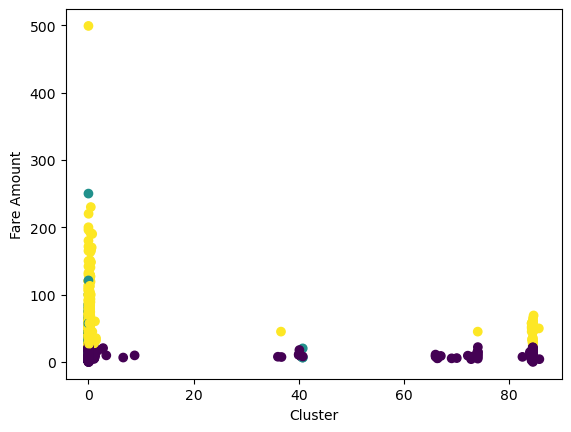

In [45]:
plt.scatter(df_added.euclidean, df_added.fare_amount, c=df_added.location)
plt.xlabel('Cluster')
plt.ylabel('Fare Amount')
plt.show()

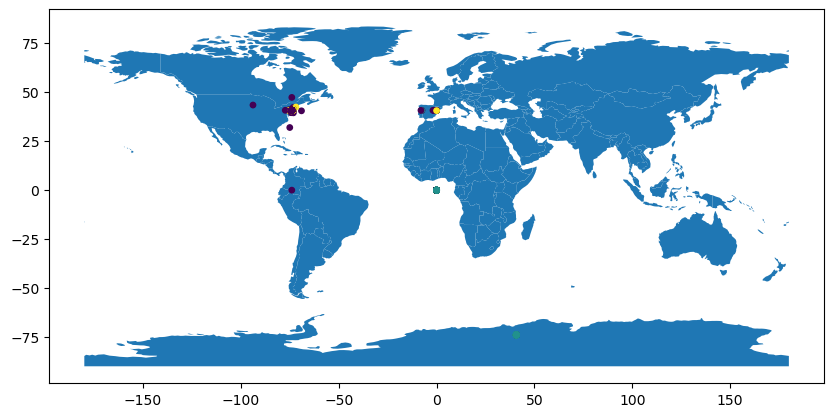

In [46]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', c=df_added.location, markersize=15, legend=True);

In [47]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

/Users/prasann/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/prasann/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/prasann/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/prasann/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

In [48]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 9.016599866909669
2 : 6.293905037357332
3 : 4.274545987659694
4 : 3.1760129567118573
5 : 3.078052108123829
6 : 3.0347783529741914
7 : 2.360550150343928
8 : 2.2777078814702865
9 : 2.1954709406328825


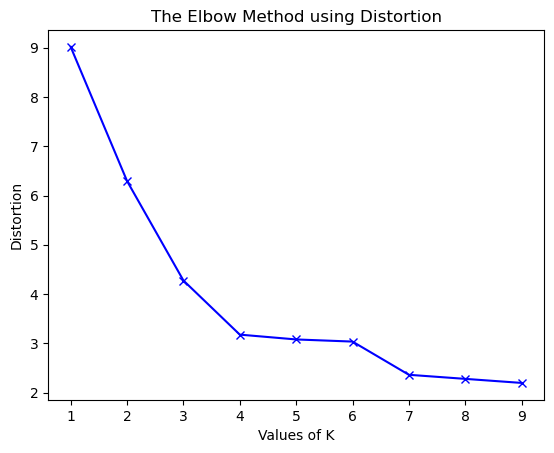

In [49]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [50]:
features

['passenger_count',
 'passenger_count',
 'passenger_count',
 'euclidean',
 'euclidean',
 'manhattan',
 'latdiff',
 'londiff']

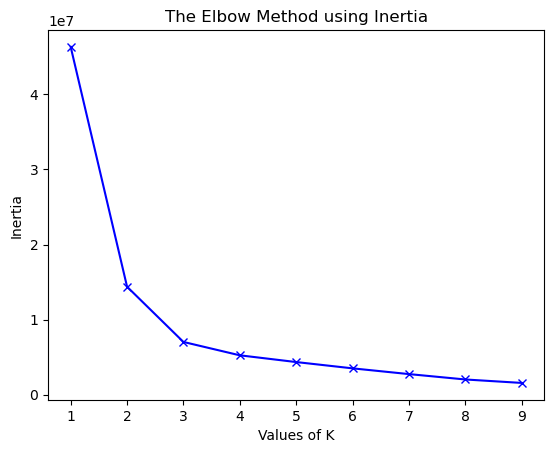

In [51]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K', )
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [52]:
X = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'fare_amount']]

# Define the number of clusters(optimal)
n_clusters = 3

# Initialize KMeans algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit KMeans to the data
kmeans.fit(X)

labels = kmeans.predict(X)

# Create a new column 'location' containing the cluster labels
df['location'] = labels

/Users/prasann/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [53]:
df_added.location

0         0
1         0
2         0
3         0
4         0
         ..
119995    0
119996    0
119997    0
119998    0
119999    0
Name: location, Length: 119981, dtype: int32

### Visualizing Categorical Variables

In [54]:
df_added.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'fare_amount', 'year', 'month',
       'day', 'hour', 'weekday', 'night', 'late_night', 'latdiff', 'londiff',
       'euclidean', 'manhattan', 'geometry', 'location'],
      dtype='object')

In [55]:
features

['passenger_count',
 'passenger_count',
 'passenger_count',
 'euclidean',
 'euclidean',
 'manhattan',
 'latdiff',
 'londiff']

### Visualizing Time Components

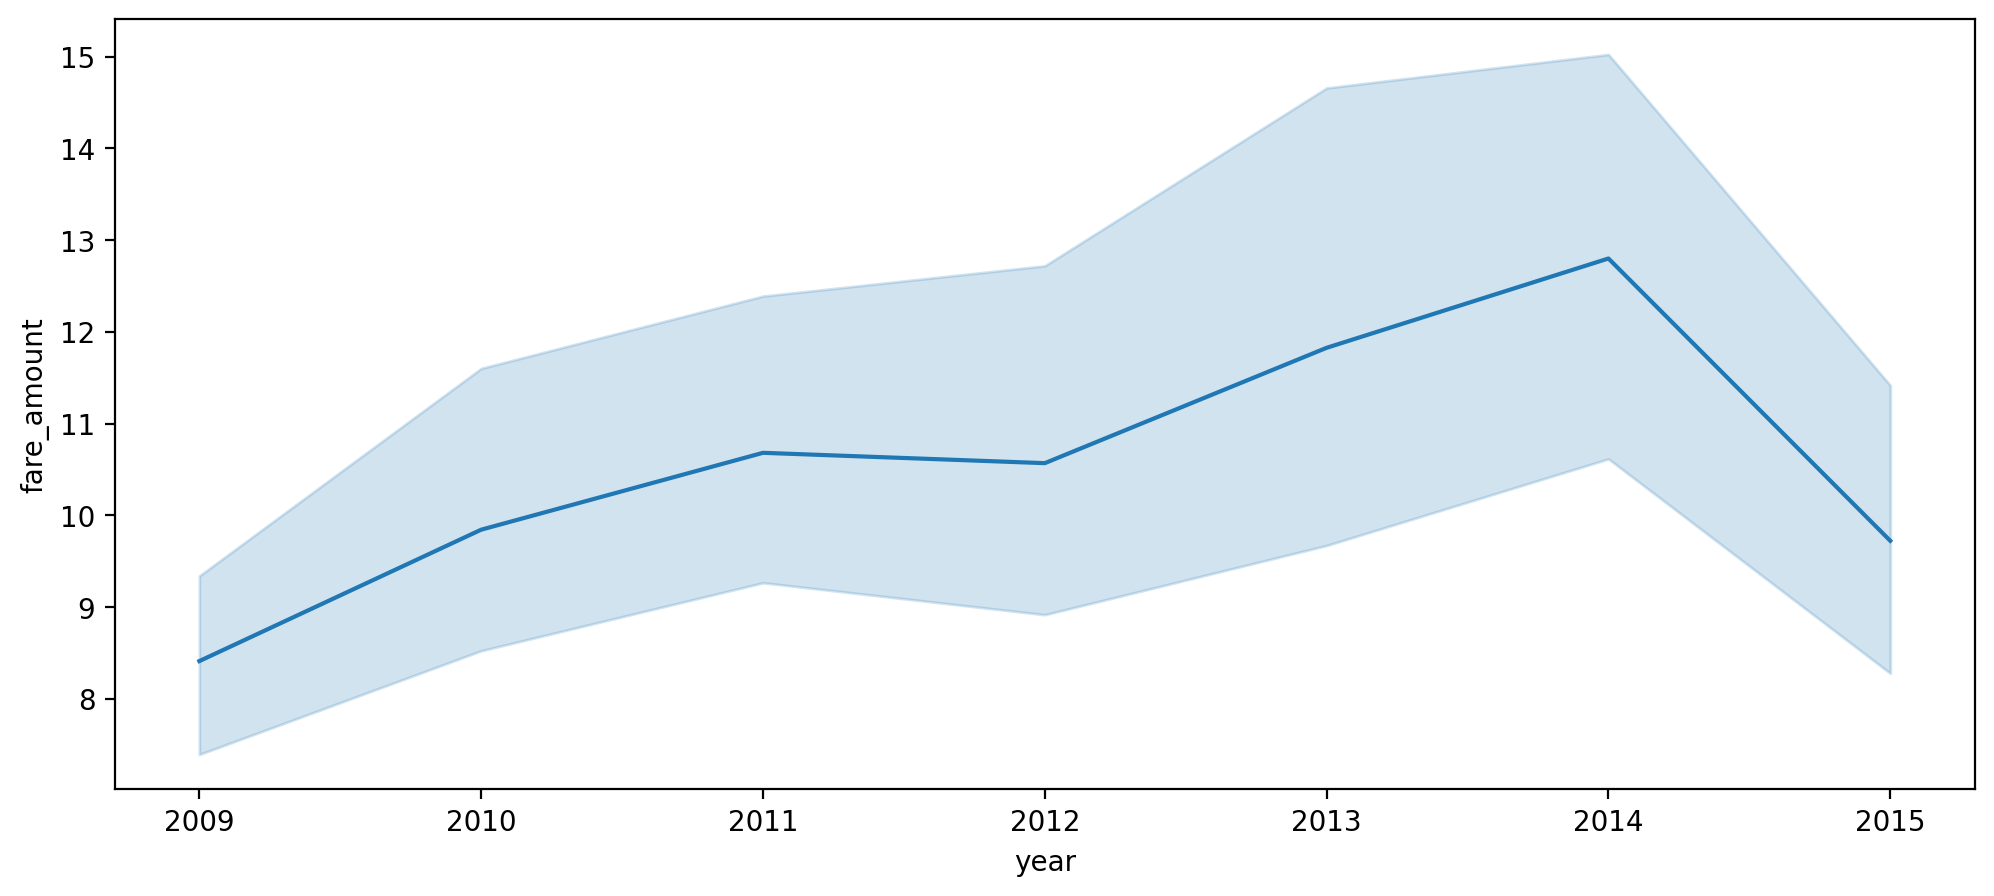

In [ ]:
feature = 'year'
plt.figure(figsize = (12,5), dpi = 200 )
sns.lineplot(x=feature, y='fare_amount', data = data)
plt.show()
c = input('Add')
if c == 'y':
    features.append(feature)

In [ ]:
monthly_fares = df_added.groupby(['year', 'month'])['fare_amount'].mean()

# Create line plot of monthly average fares
monthly_fares.plot(figsize=(10, 6))
plt.xlabel('Month-Year')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Month-Year')
plt.show()

In [ ]:
df_added.columns

In [ ]:
# Group data by week number of month and calculate average fare_amount
weekly_fares = df_added.groupby('weekday')['fare_amount'].mean()

# Create line plot of weekly average fares
weekly_fares.plot(figsize=(10, 6))
plt.xlabel('Week Number')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Week Number')
plt.show()

In [ ]:
df_added.columns

In [ ]:
features

In [ ]:
features.extend(['year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night',])

In [ ]:
df_added.columns

In [ ]:
df_added

In [ ]:
x = 'late_night'
plt.figure(figsize = (12,5), dpi = 200 )
plt.xticks(rotation = 270)
sns.barplot(x = df_added[x], y = df_added['fare_amount'])
plt.show()
c = input('add?: ')
if c == 'y':
    features.append(x)

In [ ]:
x = 'location'
plt.figure(figsize = (12,5), dpi = 200 )
plt.xticks(rotation = 270)
sns.barplot(x = df_added[x], y = df_added['fare_amount'])
plt.show()
c = input('add?: ')
if c == 'y':
    features.append(x)

In [ ]:
x = 'weekday'
plt.figure(figsize = (12,5), dpi = 200 )
plt.xticks(rotation = 270)
sns.barplot(x = df_added[x], y = df_added['fare_amount'])
plt.show()
c = input('add?: ')
if c == 'y':
    features.append(x)

In [ ]:
x = 'day'
plt.figure(figsize = (12,5), dpi = 200 )
plt.xticks(rotation = 270)
sns.barplot(x = df_added[x], y = df_added['fare_amount'])
plt.show()
c = input('add?: ')
if c == 'y':
    features.append(x)

In [ ]:
features

In [ ]:
df_added.columns

## Data Preparation

In [255]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [256]:
# Model parameters
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001
DATASET_SIZE = 119988

In [92]:
# Load values in a more compact form
datatypes = { 'fare_amount': 'float32',
              'pickup_datetime': 'datetime', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}


In [93]:
train = add_time_features(train_data)
test = add_time_features(test_data)

add_coordinate_features(train_data)
add_coordinate_features(test_data)

train = add_distances_features(train_data)
test = add_distances_features(test_data)

train.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan
43856,2010-06-03 15:50:28+00:00,-73.986735,40.761302,-73.973387,40.764520,1,6.5,2010,6,3,15,3,0,0,-0.003218,-0.013348,0.013730,0.016566
21611,2015-01-12 17:50:51+00:00,-73.992729,40.753368,-74.007721,40.740974,1,8.0,2015,1,12,17,0,1,0,0.012394,0.014992,0.019452,0.027386
91981,2014-01-19 14:11:39+00:00,-73.990858,40.733645,-73.989795,40.726372,3,5.0,2014,1,19,14,6,0,0,0.007273,-0.001063,0.007350,0.008336
78271,2014-07-16 11:17:00+00:00,-73.970918,40.758512,-74.010137,40.720202,6,19.5,2014,7,16,11,2,0,0,0.038310,0.039219,0.054825,0.077529
73647,2010-05-26 09:17:31+00:00,-73.994645,40.718463,-74.001715,40.727948,1,5.3,2010,5,26,9,2,0,0,-0.009485,0.007070,0.011830,0.016555


In [38]:
# Drop unwanted columns
dropped_columns = ['pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude','pickup_datetime']
train_clean = train.drop(dropped_columns, axis=1)
test_clean = test.drop(dropped_columns , axis=1)

# peek data
train_clean.head(5)

,passenger_count,fare_amount,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan
43856,1,6.5,2010,6,3,15,3,0,0,-0.003218,-0.013348,0.013730,0.016566
21611,1,8.0,2015,1,12,17,0,1,0,0.012394,0.014992,0.019452,0.027386
91981,3,5.0,2014,1,19,14,6,0,0,0.007273,-0.001063,0.007350,0.008336
78271,6,19.5,2014,7,16,11,2,0,0,0.038310,0.039219,0.054825,0.077529
73647,1,5.3,2010,5,26,9,2,0,0,-0.009485,0.007070,0.011830,0.016555


In [39]:
train_clean.shape

(95989, 13)

In [40]:
train_df, validation_df = train_test_split(train_clean, test_size=0.10, random_state=1)

# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values


In [41]:
#scaling
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
validation_df_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_clean)

In [43]:
model1 = Sequential()
model1.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model1.add(BatchNormalization())
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(32, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(8, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(1))

In [44]:
from keras import optimizers
adam = optimizers.Adam(lr=LEARNING_RATE)
model1.compile(loss='mse', optimizer=adam, metrics=['mae'])

/Users/prasann/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [266]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               3584      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)              

In [45]:
print('Dataset size: %s' % DATASET_SIZE)
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % train_df_scaled.shape[1])
print('Features used: %s' % train_df.columns)

Dataset size: 119988
Epochs: 50
Learning rate: 0.001
Batch size: 256
Input dimension: 13
Features used: Index(['passenger_count', 'fare_amount', 'year', 'month', 'day', 'hour',
       'weekday', 'night', 'late_night', 'latdiff', 'londiff', 'euclidean',
       'manhattan'],
      dtype='object')


In [ ]:
# Building Neural Network Models

In [46]:
#training the model
history = model1.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_df_scaled, validation_labels), 
                    shuffle=True)

Epoch 1/50
338/338 [==============================] - 2s 3ms/step - loss: 158.8640 - mae: 10.4113 - val_loss: 148.2751 - val_mae: 9.8378
Epoch 2/50
338/338 [==============================] - 1s 3ms/step - loss: 60.3133 - mae: 7.1456 - val_loss: 82.5077 - val_mae: 8.9744
Epoch 3/50
338/338 [==============================] - 1s 3ms/step - loss: 18.1429 - mae: 3.5255 - val_loss: 11.8883 - val_mae: 2.9030
Epoch 4/50
338/338 [==============================] - 1s 3ms/step - loss: 5.0005 - mae: 1.3359 - val_loss: 13.4568 - val_mae: 3.5202
Epoch 5/50
338/338 [==============================] - 1s 3ms/step - loss: 2.9927 - mae: 0.8571 - val_loss: 33.5500 - val_mae: 5.5450
Epoch 6/50
338/338 [==============================] - 1s 3ms/step - loss: 3.0097 - mae: 0.8429 - val_loss: 3.0719 - val_mae: 1.2607
Epoch 7/50
338/338 [==============================] - 1s 3ms/step - loss: 2.7790 - mae: 0.8531 - val_loss: 1.4977 - val_mae: 0.9784
Epoch 8/50
338/338 [==============================] - 1s 3ms/step

In [42]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(1, activation=None), # Output Layer
])

model_2.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics=['mse'])

model_2.fit(x = train_df_scaled,y = train_labels, epochs=100, validation_data=(validation_df_scaled, validation_labels),verbose = 1)

Epoch 1/100


2023-04-24 21:31:10.347916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2700/2700 [==============================] - 3s 883us/step - loss: 1.1799 - mse: 7.6194 - val_loss: 0.3067 - val_mse: 0.2129
Epoch 2/100
2700/2700 [==============================] - 2s 828us/step - loss: 0.5225 - mse: 0.5102 - val_loss: 0.0718 - val_mse: 0.0135
Epoch 3/100
2700/2700 [==============================] - 2s 837us/step - loss: 0.4146 - mse: 0.3153 - val_loss: 0.4236 - val_mse: 0.2398
Epoch 4/100
2700/2700 [==============================] - 2s 828us/step - loss: 0.3844 - mse: 0.2874 - val_loss: 0.2501 - val_mse: 0.0895
Epoch 5/100
2700/2700 [==============================] - 2s 858us/step - loss: 0.3684 - mse: 0.2536 - val_loss: 0.1929 - val_mse: 0.0583
Epoch 6/100
2700/2700 [==============================] - 2s 828us/step - loss: 0.3191 - mse: 0.1942 - val_loss: 0.1408 - val_mse: 0.0362
Epoch 7/100
2700/2700 [==============================] - 2s 837us/step - loss: 0.3014 - mse: 0.1745 - val_loss: 0.4426 - val_mse: 0.2257
Epoch 8/100
2700/2700 [==============================

In [265]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1400      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 31,801
Trainable params: 31,801
Non-trainable params: 0
_________________________________________________________________


In [49]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(train_df_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model_3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss='mse', metrics=['mae'])
model_3.fit(train_df_scaled, train_labels, validation_data=(validation_df_scaled, validation_labels), epochs=50, batch_size=32)


Epoch 1/50
2700/2700 [==============================] - 2s 605us/step - loss: 95.5515 - mae: 5.9176 - val_loss: 70.5882 - val_mae: 4.8085
Epoch 2/50
2700/2700 [==============================] - 2s 576us/step - loss: 82.2861 - mae: 5.6902 - val_loss: 85.2457 - val_mae: 6.1120
Epoch 3/50
2700/2700 [==============================] - 2s 576us/step - loss: 85.7489 - mae: 5.6880 - val_loss: 87.7707 - val_mae: 5.5619
Epoch 4/50
2700/2700 [==============================] - 2s 577us/step - loss: 90.9495 - mae: 5.7233 - val_loss: 28.3867 - val_mae: 4.1162
Epoch 5/50
2700/2700 [==============================] - 2s 580us/step - loss: 78.1138 - mae: 5.3554 - val_loss: 88.4039 - val_mae: 5.6812
Epoch 6/50
2700/2700 [==============================] - 2s 577us/step - loss: 87.5796 - mae: 5.5389 - val_loss: 78.9926 - val_mae: 5.2409
Epoch 7/50
2700/2700 [==============================] - 2s 576us/step - loss: 71.8430 - mae: 5.2488 - val_loss: 19.7176 - val_mae: 3.5883
Epoch 8/50
2700/2700 [============

In [267]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                896       
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


# Evaluation

In [56]:
from sklearn.metrics import r2_score
model1_scores = model1.evaluate(validation_df_scaled, validation_labels)
model1_rmse = np.sqrt(model1_scores[1])
model1_r2 = r2_score(validation_labels, model1.predict(validation_df_scaled))

# Evaluate model 2
model2_scores = model_2.evaluate(validation_df_scaled, validation_labels)
model2_rmse = np.sqrt(model2_scores[1])
model2_r2 = r2_score(validation_labels, model_2.predict(validation_df_scaled))

# Evaluate model 2
model3_scores = model_3.evaluate(validation_df_scaled, validation_labels)
model3_rmse = np.sqrt(model3_scores[1])
model3_r2 = r2_score(validation_labels, model_3.predict(validation_df_scaled))

# Compare scores
print("Model 1 RMSE:", model1_rmse)
print("Model 1 R2:", model1_r2)
print("Model 2 RMSE:", model2_rmse)
print("Model 2 R2:", model2_r2)
print("Model 3 RMSE:", model3_rmse)
print("Model 3 R2:", model3_r2)


300/300 [==============================] - 0s 364us/step
Model 1 RMSE: 1.5110730115366557
Model 1 R2: 0.939336281257965
Model 2 RMSE: 0.052373047803245365
Model 2 R2: 0.9999702397239293
Model 3 RMSE: 1.0565993887986729
Model 3 R2: 0.9694428119940237


300/300 [==============================] - 0s 626us/step


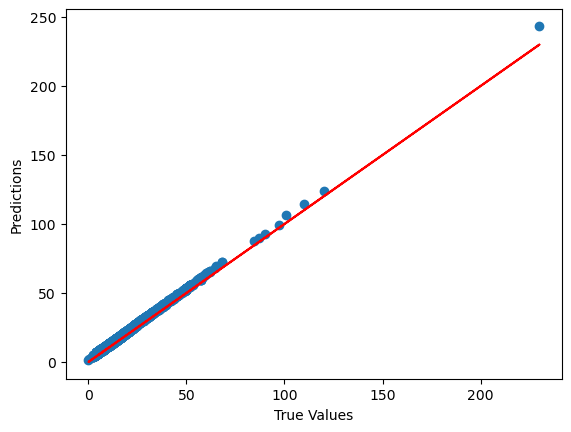

300/300 [==============================] - 0s 462us/step


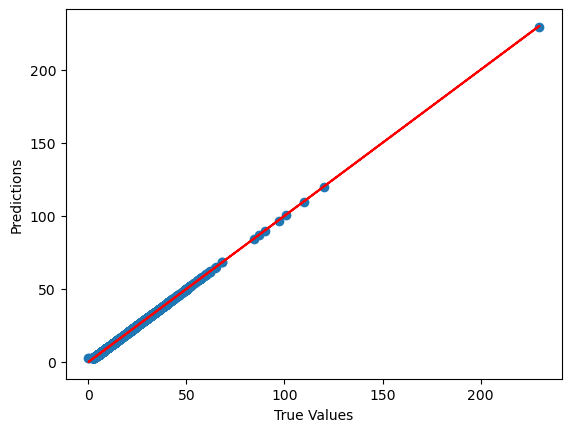

300/300 [==============================] - 0s 379us/step


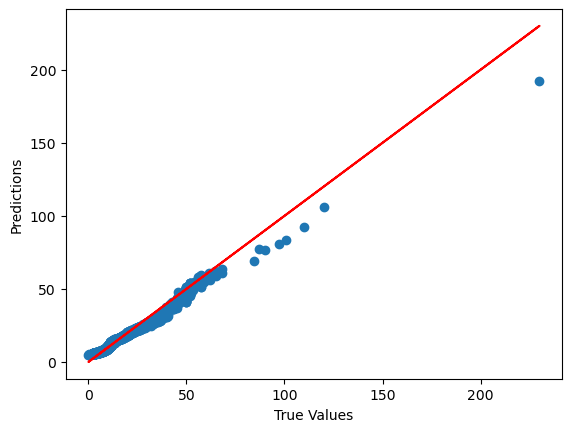

In [61]:
for x in [model1, model_2, model_3]:
    plt.scatter(validation_labels, x.predict(validation_df_scaled))
    plt.plot(validation_labels, validation_labels, color='red') # plotting the y=x line for reference
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

## Test EDA to datasets

In [ ]:
df_added.info()

In [ ]:
df_added.drop(columns=['geometry'], axis=1, inplace=True)

In [343]:
df_added.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119981 entries, 0 to 119999
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_longitude   119981 non-null  float64
 1   pickup_latitude    119981 non-null  float64
 2   dropoff_longitude  119981 non-null  float64
 3   dropoff_latitude   119981 non-null  float64
 4   passenger_count    119981 non-null  int64  
 5   fare_amount        119981 non-null  float64
 6   year               119981 non-null  int64  
 7   month              119981 non-null  int64  
 8   day                119981 non-null  int64  
 9   hour               119981 non-null  int64  
 10  weekday            119981 non-null  int64  
 11  night              119981 non-null  int64  
 12  late_night         119981 non-null  int64  
 13  latdiff            119981 non-null  float64
 14  londiff            119981 non-null  float64
 15  euclidean          119981 non-null  float64
 16  ma

In [344]:
X,y = df_added.drop(columns='fare_amount'), df_added['fare_amount']

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [346]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(X_test)

In [ ]:
X_train_

# Model Building

In [353]:
model_4 = tf.keras.Sequential([
#     tf.keras.Input(input_shape=X_train_scaled[0].shape),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(1, activation="linear"), # Output Layer
])

model_4.compile(loss=tf.keras.losses.mae, optimizer='rmsprop',metrics=['mse'])

model_4.fit(X_train_scaled,y_train, epochs=100, validation_data=(X_test_scaled,y_test))

Epoch 1/100
3000/3000 [==============================] - 3s 1ms/step - loss: 3.9648 - mse: 39.8898 - val_loss: 3.8298 - val_mse: 48.1937
Epoch 2/100
3000/3000 [==============================] - 3s 920us/step - loss: 3.8549 - mse: 37.5114 - val_loss: 3.7250 - val_mse: 48.8951
Epoch 3/100
3000/3000 [==============================] - 3s 929us/step - loss: 2.9947 - mse: 27.9490 - val_loss: 4.6098 - val_mse: 49.2696
Epoch 4/100
3000/3000 [==============================] - 3s 914us/step - loss: 2.4432 - mse: 20.9414 - val_loss: 2.5555 - val_mse: 31.2098
Epoch 5/100
3000/3000 [==============================] - 3s 907us/step - loss: 2.3002 - mse: 19.4028 - val_loss: 3.9642 - val_mse: 40.9459
Epoch 6/100
3000/3000 [==============================] - 3s 963us/step - loss: 2.2192 - mse: 18.9245 - val_loss: 3.9372 - val_mse: 40.4824
Epoch 7/100
3000/3000 [==============================] - 3s 1ms/step - loss: 2.1586 - mse: 17.9776 - val_loss: 3.9172 - val_mse: 39.3096
Epoch 8/100
3000/3000 [========

Epoch 60/100
3000/3000 [==============================] - 3s 924us/step - loss: 1.7641 - mse: 14.1418 - val_loss: 4.5722 - val_mse: 45.1496
Epoch 61/100
3000/3000 [==============================] - 3s 922us/step - loss: 1.7600 - mse: 14.0988 - val_loss: 4.5981 - val_mse: 43.7782
Epoch 62/100
3000/3000 [==============================] - 3s 916us/step - loss: 1.7586 - mse: 13.9257 - val_loss: 4.9452 - val_mse: 48.1715
Epoch 63/100
3000/3000 [==============================] - 3s 939us/step - loss: 1.7587 - mse: 13.9937 - val_loss: 5.3345 - val_mse: 51.2859
Epoch 64/100
3000/3000 [==============================] - 3s 926us/step - loss: 1.7560 - mse: 13.9024 - val_loss: 4.9820 - val_mse: 48.1965
Epoch 65/100
3000/3000 [==============================] - 3s 926us/step - loss: 1.7542 - mse: 13.8967 - val_loss: 4.7698 - val_mse: 46.2039
Epoch 66/100
3000/3000 [==============================] - 3s 930us/step - loss: 1.7527 - mse: 14.0437 - val_loss: 5.3227 - val_mse: 51.5546
Epoch 67/100
3000/30

In [355]:
model_5 = tf.keras.Sequential([
#     tf.keras.Input(input_shape=X_train_scaled[0].shape),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="tanh"),
    tf.keras.layers.Dense(100,activation="tanh"),
    tf.keras.layers.Dense(100,activation="tanh"),
    tf.keras.layers.Dense(1, activation="linear"), # Output Layer
])

model_5.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics=['mse'])

model_5.fit(X_train_scaled,y_train, epochs=100, validation_data=(X_test_scaled,y_test))

Epoch 1/100
3000/3000 [==============================] - 4s 1ms/step - loss: 5.4664 - mse: 105.1517 - val_loss: 5.4070 - val_mse: 115.7688
Epoch 2/100
3000/3000 [==============================] - 3s 1ms/step - loss: 5.4576 - mse: 105.0321 - val_loss: 5.4135 - val_mse: 115.1686
Epoch 3/100
3000/3000 [==============================] - 3s 1ms/step - loss: 5.4570 - mse: 104.9136 - val_loss: 5.4145 - val_mse: 115.0858
Epoch 4/100
3000/3000 [==============================] - 3s 1ms/step - loss: 5.4584 - mse: 105.0452 - val_loss: 5.5167 - val_mse: 124.3975
Epoch 5/100
3000/3000 [==============================] - 3s 1ms/step - loss: 5.4564 - mse: 104.9967 - val_loss: 5.4272 - val_mse: 113.9943
Epoch 6/100
3000/3000 [==============================] - 3s 999us/step - loss: 5.4572 - mse: 105.0338 - val_loss: 5.4422 - val_mse: 120.8395
Epoch 7/100
3000/3000 [==============================] - 3s 1ms/step - loss: 5.4537 - mse: 105.0084 - val_loss: 5.4174 - val_mse: 119.1341
Epoch 8/100
3000/3000 [==